In [2]:
cd /Users/bastus/Desktop/Forschungsprojekt/genimpro

/Users/bastus/Desktop/Forschungsprojekt/genimpro


In [3]:
%run importwrapper.py
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
analysedTrack = genimpro.recordings.getRecordingDetails(133)[4][0]
audio = genimpro.recordings.getAudioForTrack(analysedTrack,normalize=1)

t_silence = analysedTrack[6]
print t_silence

minGapSize = analysedTrack[7]
print minGapSize

cellBoundaries = genimpro.grouping.groupBySilence(audio,minGapSize=minGapSize,t_silence=t_silence)

0.04
12


In [155]:
from essentia.standard import *
from essentia import Pool, array
import numpy as np
from scipy.ndimage.interpolation import zoom


win_s = 512             # fft size
hop_s = win_s/2           # hop size

samplerate = 44100.0
resolution=5.0

def phenotypeForCell(cellAudio):

    
    effectiveDuration = essentia.standard.EffectiveDuration(sampleRate=samplerate,thresholdRatio=0.01)
    loudness = essentia.standard.Loudness()
    zerocrossingrate = essentia.standard.ZeroCrossingRate()
    w = essentia.standard.Windowing()
    spec = essentia.standard.Spectrum()
    SpectralPeaks = essentia.standard.SpectralPeaks(sampleRate=samplerate)
    centroid = essentia.standard.Centroid()
    SpectralComplexity = essentia.standard.SpectralComplexity(sampleRate=samplerate)
    SpectralRolloff = essentia.standard.RollOff(sampleRate=samplerate)
    SpectralFlux = essentia.standard.Flux()
    Envelope = essentia.standard.Envelope()
    TCToTotal = essentia.standard.TCToTotal()
    LAT = essentia.standard.LogAttackTime()
    Pitch = essentia.standard.PitchYinFFT(sampleRate=samplerate)
    SpectralPeaks = essentia.standard.SpectralPeaks(sampleRate=samplerate)
    Dissonance = essentia.standard.Dissonance()
    DynamicComplexity = essentia.standard.DynamicComplexity()
    SpectralPeaks = essentia.standard.SpectralPeaks(sampleRate=samplerate)
    RhythmExtractor = essentia.standard.RhythmExtractor2013()
    Key = essentia.standard.Key()
    TuningFrequency = essentia.standard.TuningFrequency()
    
    if (len(cellAudio) % 2 <> 0):
        chromaAudio = cellAudio[0:-1]
    else:
        chromaAudio = cellAudio
        
    spectrum = spec(chromaAudio)
    peaks = SpectralPeaks(spectrum)
    tuning = TuningFrequency(peaks[0],peaks[1])
    
    HPCP = essentia.standard.HPCP(sampleRate=samplerate, referenceFrequency =tuning[0])
    chroma = HPCP(peaks[0],peaks[1])

    
    eff_duration = effectiveDuration(cellAudio)
 
    featurelist = ["ZCR","SpectralCentroid","SpectralComplexity","Roughness","Loudness"]
    features = {}
    
    for feature in featurelist:
        features[feature] = {}
        features[feature]["raw"]=[0]
    
    chromaKeys = ["A","A#","B","C","C#","D","D#","E","F","F#","G","G#"]
    
    for i,key in enumerate(chroma.tolist()):
        features["Chroma " + chromaKeys[i]] = key
        
    features["DynamicComplexity"] = list(DynamicComplexity(cellAudio))[0]/25
    #features["SpectralCentroidA"]= centroid(spectrum)
    #features["SpectralRolloffA"] = SpectralRolloff(spectrum)
    ###features["SpectralFluxA"] = SpectralFlux(spectrum)
    #features["SpectralComplexityA"] = SpectralComplexity(spectrum)
    #features["RoughnessA"] = Dissonance(peaks[0],peaks[1])
    features["Rhythm"] = RhythmExtractor(cellAudio)[0]/200
    #features["ZCRA"] = zerocrossingrate(cellAudio)
    features["Density"] = eff_duration * samplerate / len(cellAudio)
    
    
    for featureframe in FrameGenerator(cellAudio, frameSize = hop_s, hopSize = hop_s/2):
        features["Loudness"]["raw"].append(loudness(featureframe))
        features["ZCR"]["raw"].append(zerocrossingrate(featureframe))
        #features["Loudness"]["raw"].append(loudness(featureframe))
        spectrum = spec(w(featureframe))
        features["SpectralCentroid"]["raw"].append(centroid(spectrum))
        features["SpectralComplexity"]["raw"].append(SpectralComplexity(spectrum))
        #features["SpectralRolloff"]["raw"].append(SpectralRolloff(spectrum))
       
        peaks = SpectralPeaks(spectrum)
        features["Roughness"]["raw"].append(Dissonance(peaks[0],peaks[1])*10.0)
        #features["SpectralFlux"]["raw"].append(SpectralFlux(spectrum))
    
    for feature in featurelist:
        t = np.linspace(0, len(features[feature]["raw"]), num=len(features[feature]["raw"]))
        features[feature + " variance"]=np.var(features[feature]["raw"])
        #features[feature]["stdev"]=np.std(features[feature]["raw"])
        features[feature + " corrcoef"]=np.corrcoef(t,features[feature]["raw"])[0][1]
        features[feature] = np.median(features[feature]["raw"])
        #zoomFactor = 1/(len(features[feature]["raw"])/resolution)
        #features[feature +  "I"] = zoom(features[feature]["raw"],zoomFactor)
        #features[feature].pop("raw",None)
    
    
    return features

In [88]:
recordingIDs = [105,135,200,320]
tracks = []

In [92]:
analysedTrack = genimpro.recordings.getRecordingDetails(320)[4][0]
audio = genimpro.recordings.getAudioForTrack(analysedTrack,normalize=1)

tracks.append([analysedTrack,audio]) 

In [156]:
for i,track in enumerate(tracks):
    cellBoundaries = genimpro.recordings.getSequencesForTrack(track[0])

    cellPhenotypes = []

    for cell in cellBoundaries[0:5]:

        cellAudio = track[1][cell[0]:cell[1]]

        cellPhenotype = phenotypeForCell(cellAudio)
        cellPhenotypes.append(cellPhenotype)
    
    tracks[i].append(cellPhenotypes)

In [157]:
cellPhenotype = phenotypeForCell(audio[cellBoundaries[3][0]:cellBoundaries[3][1]])
cellPhenotype

{'Chroma A': 0.2032899558544159,
 'Chroma A#': 0.599216103553772,
 'Chroma B': 0.15888947248458862,
 'Chroma C': 0.9988829493522644,
 'Chroma C#': 0.12865327298641205,
 'Chroma D': 0.15844663977622986,
 'Chroma D#': 0.5696614384651184,
 'Chroma E': 0.05832909420132637,
 'Chroma F': 0.0986609011888504,
 'Chroma F#': 0.8060754537582397,
 'Chroma G': 0.44050341844558716,
 'Chroma G#': 1.0,
 'Density': 0.5635653273202479,
 'DynamicComplexity': 0.0,
 'Loudness': 0.023193617351353168,
 'Loudness corrcoef': -0.11513636727791979,
 'Loudness variance': 0.02239899571858537,
 'Rhythm': 0.0,
 'Roughness': 0.068380944430828094,
 'Roughness corrcoef': -0.36936261992215424,
 'Roughness variance': 0.036435631723409259,
 'SpectralCentroid': 0.045072184875607491,
 'SpectralCentroid corrcoef': -0.3151267165651806,
 'SpectralCentroid variance': 0.00078020185244982287,
 'SpectralComplexity': 0.0,
 'SpectralComplexity corrcoef': -0.031917803052315653,
 'SpectralComplexity variance': 0.44888888888888823,
 'Z

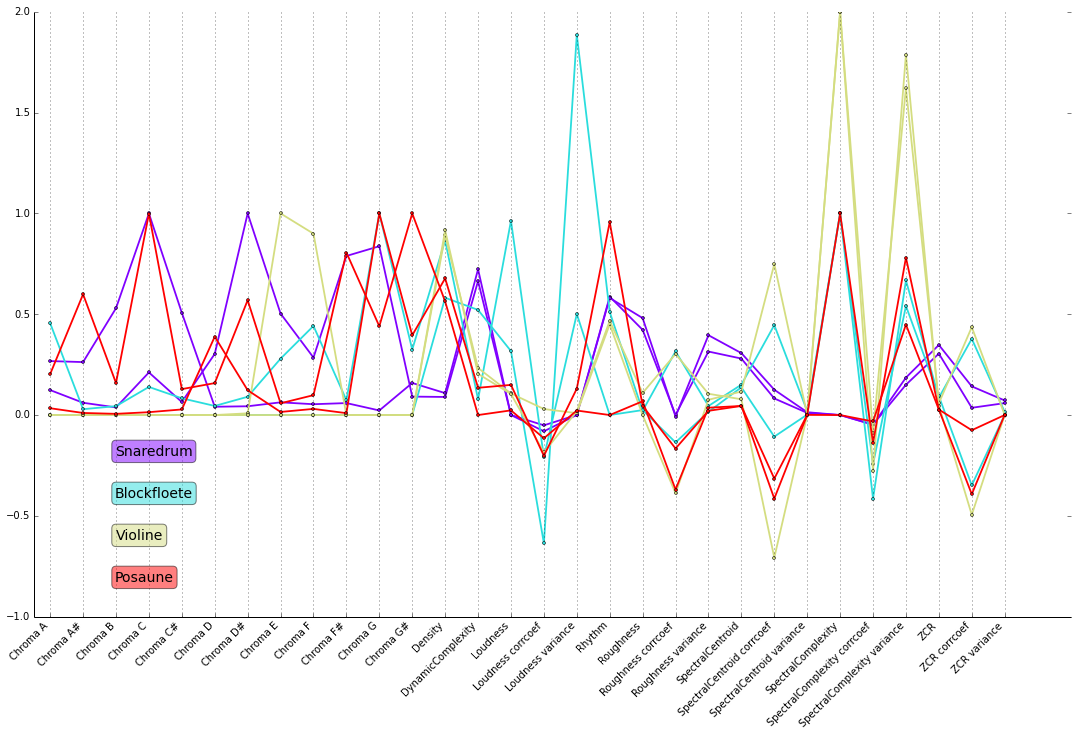

In [160]:
colors = cm.rainbow(np.linspace(0, 1, len(tracks)))
legend = ["Snaredrum","Blockfloete","Violine","Posaune"]


x_axis = range(0,len(cellPhenotype))
labels = sorted(cellPhenotype.keys())

fig = plt.figure(figsize=(18, 12))
ax = fig.add_axes((0.1, 0.2, 0.8, 0.7))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(x_axis, labels, rotation='45',ha="right")
ax.set_xlim([-0.5, len(cellPhenotype)+1])
ax.xaxis.grid(True)

for i,track in enumerate(tracks):

    for cellPhenotype in track[-1][3:6]:

        sortedValues= []
        for key in labels:
            sortedValues.append(cellPhenotype[key])


        ax.plot(x_axis,sortedValues,color=colors[i],marker='o',lw=1.8,ms=3)
    
    ax.text(2, -0.2 - i/4.8,'%s'% (legend[i]),bbox=dict(boxstyle='round',facecolor=colors[i], alpha=0.5),fontsize=14,horizontalalignment='left')

    
plt.show()

In [8]:
flatten(cellPhenotypes[10].values())

<generator object flatten at 0x11065c690>